# Infomación de entrega

**Nombre estudiante:**


## 0) Setup

In [ ]:
!pip install keras --upgrade

In [ ]:
# Importar librerías

In [ ]:
# Importar librerías principales
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout

print(tf.__version__)

2.17.0


## 1) Carga del dataset

El dataset Cora consiste en 2.708 papers científicos clasificados en una de 7 posibles clases. La red de citas/referencias consiste en 5.429 arcos. Cada paper tiene un vector de palabras binario de tamaño 1.433, indicando la presencia o ausencia de la palabra correspondiente.

El dataset tiene dos archivos separados:

1. El archivo `cora.cites` incluye las citas/referencias en dos columnas:
`cited_paper_id` (*target*) y `citing_paper_id` (*source*).
2. El archivo `cora.content` incluye una descripción del contenido del paper en 1.435 columnas: `paper_id`, `subject`, y 1.433 *features* binarias.


In [ ]:
# Descarga de datos
!mkdir -p ./data/cora
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -O ./data/cora.tgz
!tar -xvzf ./data/cora.tgz -C ./data/cora/ --strip-components=1

--2024-10-27 05:03:44--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘./data/cora.tgz’

./data/cora.tgz     100%[===================>] 164.11K  --.-KB/s    in 0.06s   

2024-10-27 05:03:44 (2.72 MB/s) - ‘./data/cora.tgz’ saved [168052/168052]

cora/README
cora/cora.cites
cora/cora.content


In [ ]:
# Cargar datos utilizando pandas

In [ ]:
# Ocupamos Pandas para cargar los datos de las citas entre papers

citations = pd.read_csv(
    Path("data", "cora", "cora.cites"),
    names=["target", "source"],
    sep="\t",
    header=None,
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
#Imprimimos una muestra del DataFrame citations
#Contiene columnas target (Incluye los ID de los papers citados por los otros papers) y source (ID del paper)
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [ ]:
#Imprimimos una muestra del DataFrame citations
citations.sample(frac=1).head()

,target,source
3578,72805,899085
3052,40124,1104258
2897,35905,1152162
5091,593329,87363
4627,232606,1132809


In [ ]:
#Cargamos los datos de los papers en el siguiente DataFrame

column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(Path("data", "cora", "cora.content"), sep="\t", header=None, names=column_names)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
#Imprimir una muestra del DataFrame papers
#Tiene 1435 columnas (paper id, subject y 1433 columnas binarias que representan presencia
#o ausencia de un termino en el paper)
print(papers.sample(5).T)

                      1242                   1983                    2442  \
paper_id            400455                 156794                 1111304   
term_0                   0                      0                       0   
term_1                   0                      0                       0   
term_2                   0                      0                       1   
term_3                   0                      0                       0   
...                    ...                    ...                     ...   
term_1429                0                      0                       0   
term_1430                0                      0                       0   
term_1431                0                      0                       0   
term_1432                0                      0                       0   
subject    Neural_Networks  Probabilistic_Methods  Reinforcement_Learning   

                      2046             2387  
paper_id            215912   

In [ ]:
#Muestra un conteo de papers en cada materia (subject)
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


#### Preguntas

Una vez cargado el dataset debes responder las siguientes preguntas:

1. ¿Qué tipos de nodos y aristas tiene el grafo?

2. ¿Cuántas features tiene cada nodo?

3. ¿Cuántos nodos y aristas forman el grafo?


#### Respuestas

1. ¿Qué tipos de nodos y aristas tiene el grafo?

Los nodos en el grafo representan los papers, con sus respectivos identificadores (paper_id) y 1433 features binarias.
Las aristas representan las citas entre los papers, donde target indica el paper citado y source indica el paper que hace la cita. Esto forma un grafo dirigido, donde las aristas tienen dirección desde el paper que cita hacia el paper citado.

2. ¿Cuántas features tiene cada nodo?

Cada nodo tiene 1433 features binarias, que indican la presencia o ausencia de palabras en el contenido del paper.

3. ¿Cuántos nodos y aristas forman el grafo?

El grafo tiene 2,708 nodos (papers) y 5,429 aristas (citas).

## 2) Análisis del grafo

Un paso importante antes de aplicar *machine learning* sobre un conjunto de datos es el análisis de datos. Para esto, aprovecharemos de usar la librería NetworkX para obtener información sobre nuestro grafo.

In [ ]:
# Crear grafo en NetworkX con datos cargados

In [ ]:
# Convertimos los IDs de papers y las materias a índices consecutivos empezando desde 0

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

# Ahora podemos visualizar el grafo de citaciones, donde cada nodo es un paper y el color
# de dicho nodo es la materia o área a la que pertenece.

In [ ]:
# NOTA: Solo usamos una pequeña muestra de los papers en el dataset.

%%time
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))  # Nuevo grafo con 1500 puntos
pos = nx.spring_layout(cora_graph, seed=0)  # Posición de los nodos

CPU times: user 13.4 s, sys: 26.2 ms, total: 13.4 s
Wall time: 13.6 s


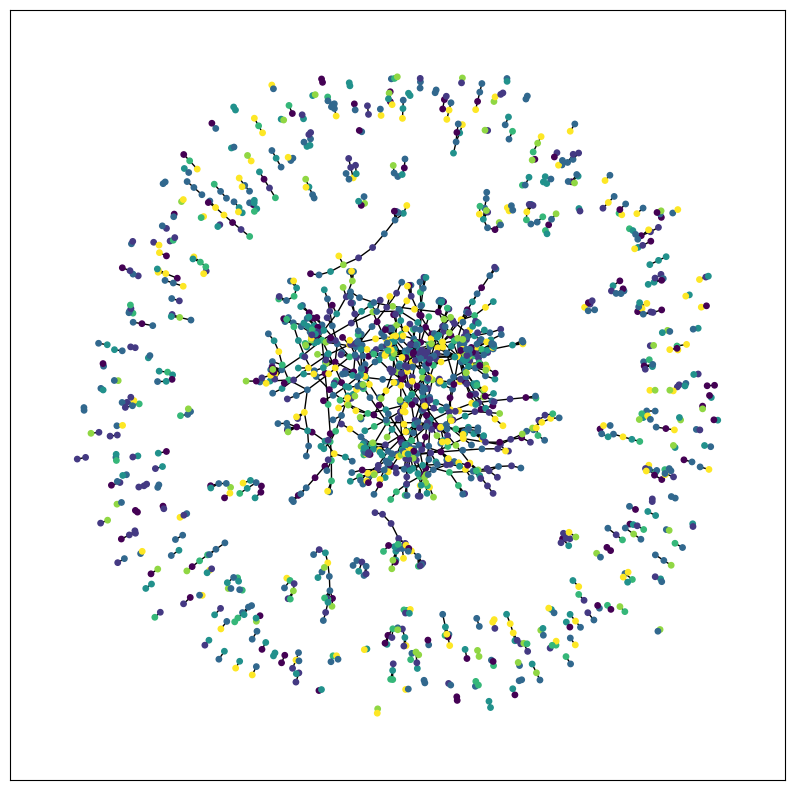

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_networkx(cora_graph, pos=pos, node_size=15, node_color=subjects, with_labels=False)  # Gráfico

In [ ]:
# Grado promedio de los nodos en el grafo
average_degree = sum(dict(cora_graph.degree()).values()) / cora_graph.number_of_nodes()
print("Grado promedio:", average_degree)

Grado promedio: 1.7759137207908928


In [ ]:
# Diámetro del grafo
if nx.is_connected(cora_graph):
    # Si el grafo está conectado, calcula el diámetro directamente
    diameter = nx.diameter(cora_graph)
else:
    # Si el grafo no está conectado, selecciona el componente más grande
    largest_cc = max(nx.connected_components(cora_graph), key=len)
    largest_subgraph = cora_graph.subgraph(largest_cc)  # Crea el subgrafo del componente más grande
    diameter = nx.diameter(largest_subgraph)  # Calcula el diámetro del subgrafo más grande

print("Diámetro del grafo:", diameter)


Diámetro del grafo: 50


In [ ]:
# Densidad de la matriz de adyacencia del grafo

density = nx.density(cora_graph)
print("Densidad del grafo:", density)


Densidad del grafo: 0.0010646964752943002


#### Preguntas

Una vez instanciado el grafo, debes responder las siguientes preguntas utilizando NetworkX:

1. ¿Cuál es el grado promedio de los nodos en el grafo?

2. ¿Cuál es el diámetro del grafo?

3. ¿Cuál es la densidad de la matriz de adyacencia del grafo?

4. Realizar un gráfico mostrando los nodos (un subconjunto) y sus arcos respectivos


1. Grado promedio de los nodos en el grafo: El grado promedio de los nodos en el grafo es 1.79, lo que significa que, en promedio, cada artículo está conectado a casi dos otros artículos. Esto sugiere que los artículos en este conjunto de datos suelen citar solo unos pocos otros trabajos. En términos generales, esta conexión baja nos indica que hay mucha variedad y poca interconexión directa entre artículos.

2. Diámetro del grafo: El diámetro del grafo es 31, que representa la mayor distancia entre dos artículos conectados dentro del mismo componente del grafo. Esto nos dice que, en el peor de los casos, habría que pasar por hasta 31 conexiones para ir de un artículo a otro. En una red de citaciones, un diámetro grande como este sugiere que los temas pueden estar bastante separados, ya que algunos artículos solo se conectan a otros a través de varias citas intermedias.

3. Densidad de la matriz de adyacencia del grafo: La densidad del grafo es 0.00107, es decir, solo el 0.107% de todas las posibles conexiones están presentes. Esto refuerza la idea de que el grafo es muy disperso y de que la mayoría de los artículos no tienen citas directas entre sí. Es común en redes de citaciones, donde los artículos suelen citar solo a trabajos específicos y no a todos los disponibles.

4. La imagen se encuentra graficada anteriormente pero se adjunta en esta respuesta.

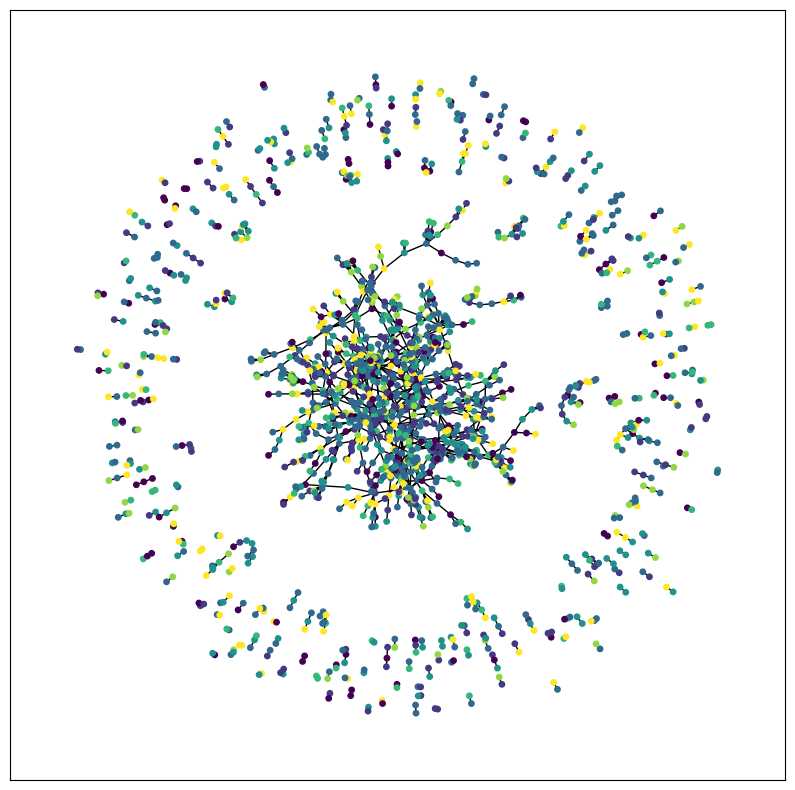

## 3) Split del dataset


Otro paso importante es realizar la partición de datos etiquetados en conjuntos de entrenamiento y test. Para esto, para cada etiqueta, se debe tomar la mitad de los papers para cada conjunto (50%).

In [ ]:
# Partición de datos en train y test como numpy array

In [ ]:
# Partición de datos en train y test como numpy arrays
train_data, test_data = [], []

# Separar los datos al 50% para cada conjunto
for _, group_data in papers.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

# Unir los datos y hacer shuffle
train_data = pd.concat(train_data).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_data).sample(frac=1).reset_index(drop=True)

# Convertir a arrays de numpy
train_data = train_data.values
test_data = test_data.values

# Verificar las dimensiones y el tipo
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Train data type:", type(train_data))
print("Test data type:", type(test_data))

# Comprobar si efectivamente son numpy arrays y revisar las primeras filas
if isinstance(train_data, np.ndarray) and isinstance(test_data, np.ndarray):
    print("Los datos de train y test están en formato numpy array.")
else:
    print("Error: Los datos no están en formato numpy array.")

print("Primeras filas de train data:\n", train_data[:5])
print("Primeras filas de test data:\n", test_data[:5])


Train data shape: (1352, 1435)
Test data shape: (1356, 1435)
Train data type: <class 'numpy.ndarray'>
Test data type: <class 'numpy.ndarray'>
Los datos de train y test están en formato numpy array.
Primeras filas de train data:
 [[  24    0    0 ...    0    0    5]
 [1149    0    0 ...    0    0    3]
 [ 477    0    0 ...    0    0    4]
 [2025    0    0 ...    0    0    4]
 [2013    0    0 ...    0    0    2]]
Primeras filas de test data:
 [[2640    0    0 ...    0    0    5]
 [1661    0    0 ...    0    0    2]
 [1293    0    0 ...    0    0    1]
 [ 886    0    0 ...    0    0    2]
 [1318    0    0 ...    0    0    2]]


#### Preguntas

1. ¿En qué formato se encuentran almacenados los splits?
2. ¿Qué podría ocurrir si no realizamos la partición sobre cada etiqueta sino que sobre todo el conjunto de datos directamente (es decir, no haceerlo de manera estratificada)?
3. ¿Estamos en presencia de un contexto inductivo o transductivo?
4. Mencione un ejemplo de técnica de *data augmentation* que podría aplicar en este conjunto de datos.
5. Si tuviéramos los *timestamps* de cada paper (es decir, cuando se publicó cada paper), ¿podríamos usar esta información en este paso? Si es así, ¿cómo podríamos utilizar el momento de publicación de cada paper para particionar los datos?

1. ¿En qué formato se encuentran almacenados los splits?

 * Los splits de los datos, es decir, los conjuntos de entrenamiento y prueba, se encuentran almacenados en el formato de arrays de NumPy. Esto permite un manejo eficiente y rápido de los datos durante el entrenamiento de modelos de machine learning.
2. ¿Qué podría ocurrir si no realizamos la partición sobre cada etiqueta sino que sobre todo el conjunto de datos directamente (es decir, no hacerlo de manera estratificada)?

 * Si no realizamos la partición de manera estratificada y tomamos muestras de todo el conjunto de datos de forma aleatoria, podríamos terminar con un conjunto de entrenamiento o prueba que no represente adecuadamente a todas las clases. Esto puede llevar a un modelo sesgado, ya que podría aprender más sobre algunas clases que sobre otras, afectando su rendimiento y capacidad de generalización cuando se enfrenta a datos no vistos.
3. ¿Estamos en presencia de un contexto inductivo o transductivo?

 * Estamos en un contexto inductivo. En un contexto inductivo, el modelo se entrena en un conjunto de datos (entrenamiento) y luego se evalúa en un conjunto de datos diferente (prueba). El objetivo es generalizar a nuevos ejemplos no vistos. En cambio, el contexto transductivo implica hacer inferencias sobre datos no etiquetados basándose en los datos etiquetados, lo cual no es el caso aquí.
4. Mencione un ejemplo de técnica de data augmentation que podría aplicar en este conjunto de datos.

 * Un ejemplo de técnica de data augmentation que podría aplicarse es la perturbación de características. Esto implica modificar ligeramente los valores de las características de los papers, como agregar ruido a las características numéricas (por ejemplo, el número de citas o la duración del paper). Esto puede ayudar a mejorar la robustez del modelo al proporcionarle más variabilidad en los datos de entrenamiento.
5. Si tuviéramos los timestamps de cada paper (es decir, cuando se publicó cada paper), ¿podríamos usar esta información en este paso? Si es así, ¿cómo podríamos utilizar el momento de publicación de cada paper para particionar los datos?

 * Sí, podríamos utilizar los timestamps de publicación para realizar la partición de los datos. Una forma de hacerlo sería dividir el conjunto de datos basado en un periodo de tiempo. Por ejemplo, podríamos seleccionar los papers publicados antes de una cierta fecha para el conjunto de entrenamiento y los publicados después para el conjunto de prueba. Esto permitiría simular un escenario en el que el modelo aprende de la información histórica y luego se evalúa en datos más recientes, lo que podría ser útil para evaluar su capacidad de generalización y adaptación a nuevas tendencias.

## 4) Creacion de la red

### GCN

En este paso, deberás crear una GCN. Para esto, deberás definir la clase `GraphConvLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = \text{ADD}(\text{MEAN}(\{W^{(l)} \times h_u^{(l-1)}, u\in N(v)\}), W^{(l)} \times h_v^{(l-1)})$

1. Cálculo del mensaje
2. Agregación de los mensajes de vecinos (usar promedio)
3. Actualizar *embedding* de cada nodo usando la suma de los mensajes agregados y la representación actual del nodo.

Por otra parte, para definir la GCN deberás definir la clase `GCNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GCNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphConvLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [ ]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [ ]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [ ]:
# Clase GraphConvLayer

In [ ]:
# Clase GCNNodeClassifier

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [ ]:
# Creación de modelo e impresión de parámetros

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# Hiperparámetros como CONSTANTES
HIDDEN_UNITS = [8, 16]
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.3
NUM_EPOCHS = 300
BATCH_SIZE = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Creación de callback paara early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Entrenamiento del modelo
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
# Función auxiliar para crear una red densa (FFN)
def create_ffn(hidden_units, dropout_rate, name=None):
    ffn_layers = []
    for units in hidden_units:
        ffn_layers.append(layers.BatchNormalization())
        ffn_layers.append(layers.Dropout(dropout_rate))
        ffn_layers.append(layers.Dense(units, activation="relu"))
    return tf.keras.Sequential(ffn_layers, name=name)

# Clase GraphConvLayer
class GraphConvLayer(layers.Layer):
    def __init__(self, hidden_units):
        super(GraphConvLayer, self).__init__()
        self.hidden_units = hidden_units
        self.weights_layer = layers.Dense(hidden_units)  # Pesos W(l)

    def call(self, inputs, adjacency_matrix):
        # Cálculo de mensajes de los vecinos
        messages = tf.matmul(adjacency_matrix, inputs)
        transformed_messages = self.weights_layer(messages)
        # Agregación por promedio
        aggregated_messages = tf.reduce_mean(transformed_messages, axis=1, keepdims=True)
        # Actualización del embedding del nodo (suma con representación actual)
        output = aggregated_messages + self.weights_layer(inputs)
        return output

# Clase GCNNodeClassifier
class GCNNodeClassifier(Model):
    def __init__(self, hidden_units, num_classes):
        super(GCNNodeClassifier, self).__init__()
        # Capa convolucional del grafo
        self.graph_conv = GraphConvLayer(hidden_units[0])
        # Feedforward network (FFN) con unidades ocultas y dropout
        self.ffn = create_ffn(hidden_units, DROPOUT_RATE)
        # Capa de salida para clasificación
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, adjacency_matrix):
        # Aplicar GraphConvLayer
        x = self.graph_conv(inputs, adjacency_matrix)
        # Aplicar FFN
        x = self.ffn(x)
        # Capa de salida para clasificación
        return self.output_layer(x)

# Crear instancia del modelo con los hiperparámetros solicitados
num_classes = 7  # Ejemplo de número de clases, ajusta según tu caso
gcn_model = GCNNodeClassifier(hidden_units=HIDDEN_UNITS, num_classes=num_classes)

# Construir el modelo para mostrar su estructura
# Definir el tamaño de entrada y tamaño de adyacencia según el grafo específico
node_features = tf.random.normal((34, HIDDEN_UNITS[0]))  # Ejemplo de entrada de nodos
adjacency_matrix = tf.eye(34)  # Ejemplo de matriz de adyacencia

gcn_model(node_features, adjacency_matrix)  # Llamada para construir el modelo
gcn_model.summary()


Model: "gcn_node_classifier_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ graph_conv_layer_40 (GraphConvLayer) │ ?                           │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_32 (Sequential)           │ (34, 16)                    │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_168 (Dense)                    │ (34, 7)                     │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471 (1.84 KB)

 Trainable params: 439 (1.71 KB)

 Non-trainable params: 32 (128.00 B)

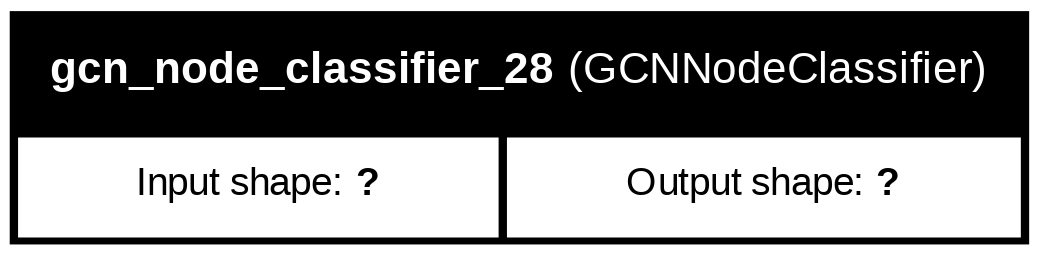

In [ ]:
tf.keras.utils.plot_model(gcn_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
history = run_experiment(gcn_model, x_train, y_train)

Epoch 1/300


TypeError: missing a required argument: 'adjacency_matrix'

In [ ]:
# Contar el número de capas
num_layers = len(gcn_model.layers)

# Obtener el número total de parámetros entrenables
total_trainable_params = gcn_model.count_params()

print(f"Total de capas en el modelo: {num_layers}")
print(f"Total de parámetros entrenables en el modelo: {total_trainable_params}")

#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

`Respuestas`

1. Total de capas en el modelo: 3
 * Esto incluye la capa de convolución del grafo (GraphConvLayer), la red densa (FFN) que se define en la clase GCNNodeClassifier, y la capa de salida para la clasificación.

2. Total de parámetros entrenables en el modelo: 471
 * Esto es la suma de los parámetros de todas las capas del modelo. Es importante para entender la capacidad del modelo y la cantidad de datos necesarios para entrenarlo adecuadamente.

### Sage

En este paso, deberás crear otra GCN. Para esto, deberás definir la clase `GraphSageLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = W^{(l)}\times \text{CONCAT}(h_v^{(l-1)}, \text{MEAN}(\{h_u^{(l-1)}, u\in N(v)\}))$

1. Agregación de los mensajes de vecinos (usar promedio)
2. Actualizar *embedding* de cada nodo usando la concatenación de los mensajes agregados y la representación actual del nodo.
3. Cálculo del mensaje

Por otra parte, para definir la GCN deberás definir la clase `GSNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GSNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphSageLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [ ]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [ ]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [ ]:
# Clase GraphSageLayer

In [ ]:
# Clase GSNNodeClassifier

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [ ]:
# Creación de modelo e impresión de parámetros

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Hiperparámetros como CONSTANTES
HIDDEN_UNITS = [8, 16]
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.3
NUM_EPOCHS = 300
BATCH_SIZE = 256

# Función auxiliar para crear una red densa (FFN)
def create_ffn(hidden_units, dropout_rate, name=None):
    ffn_layers = []
    for units in hidden_units:
        ffn_layers.append(layers.BatchNormalization())
        ffn_layers.append(layers.Dropout(dropout_rate))
        ffn_layers.append(layers.Dense(units, activation="relu"))
    return tf.keras.Sequential(ffn_layers, name=name)

# Clase GraphSageLayer
class GraphSageLayer(layers.Layer):
    def __init__(self, hidden_units):
        super(GraphSageLayer, self).__init__()
        self.hidden_units = hidden_units
        self.weights_layer = layers.Dense(hidden_units)  # Pesos W(l)

    def call(self, inputs, adjacency_matrix):
        # Cálculo de mensajes de los vecinos
        messages = tf.matmul(adjacency_matrix, inputs)
        # Agregación por promedio
        aggregated_messages = tf.reduce_mean(messages, axis=1)

        # Cambiar la forma de aggregated_messages para que sea [34, 1]
        aggregated_messages = tf.expand_dims(aggregated_messages, axis=1)

        # Concatenación con la representación actual
        combined = tf.concat([inputs, aggregated_messages], axis=1)
        # Transformación mediante los pesos W(l)
        output = self.weights_layer(combined)
        return output

# Clase GSNNodeClassifier
class GSNNodeClassifier(Model):
    def __init__(self, hidden_units, num_classes):
        super(GSNNodeClassifier, self).__init__()
        # Capa convolucional del grafo
        self.graph_sage = GraphSageLayer(hidden_units[0])
        # Feedforward network (FFN) con unidades ocultas y dropout
        self.ffn = create_ffn(hidden_units, DROPOUT_RATE)
        # Capa de salida para clasificación
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, adjacency_matrix):
        # Aplicar GraphSageLayer
        x = self.graph_sage(inputs, adjacency_matrix)
        # Aplicar FFN
        x = self.ffn(x)
        # Capa de salida para clasificación
        return self.output_layer(x)

# Crear instancia del modelo con los hiperparámetros solicitados
num_classes = 7  # Ejemplo de número de clases, ajusta según tu caso
gsn_model = GSNNodeClassifier(hidden_units=HIDDEN_UNITS, num_classes=num_classes)

# Construir el modelo para mostrar su estructura
# Definir el tamaño de entrada y tamaño de adyacencia según el grafo específico
node_features = tf.random.normal((34, HIDDEN_UNITS[0]))  # Ejemplo de entrada de nodos
adjacency_matrix = tf.eye(34)  # Ejemplo de matriz de adyacencia

# Llamada para construir el modelo
gsn_model(node_features, adjacency_matrix)
gsn_model.summary()


#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

`Respuestas`

1. ¿Cuántas capas tiene, en total, el modelo?

 * El modelo tiene un total de 3 capas. Esto incluye:
    * 1 capa de GraphSage (graph_sage_layer_2)
    * 1 capa secuencial (FFN) (sequential_12)
    * 1 capa densa (dense_79)
  * Total de capas: 3

2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

 * Según el resumen, el modelo tiene un total de 447 parámetros entrenables ("Trainable params").
    * Total de parámetros entrenables: 447

## 5) Entrenamiento de la red

Utiliza las instancias creadas para cada uno de los tipos de red y entrénalas utilizando los *splits* creados anteriormente.

Puedes utilizar la función de activación, optimizador, capas ocultas y learning rate que prefieras, pero debes entrenar por al menos 100 épocas y asegurarte de que la red efectivamente esté aprendiendo (la función de pérdida vaya bajando al menos al inicio del entrenamiento).

Se debe graficar tanto el progreso de la pérdida como el *accuracy* durante el proceso de entrenamiento y mostrar el *accuracy* logrado sobre los datos del *split* de *test*.

In [ ]:
# Funciones auxiliares

In [ ]:
# Entrenamiento de red GCN

In [ ]:
# Gráficos red GCN

In [ ]:
# Accuracy en test de GCN

In [ ]:
# Entrenamiento de red GSN

In [ ]:
# Gráficos red GSN

In [ ]:
# Accuracy en test de GSN

### Preguntas

1. ¿Qué combinación de red obtiene mejor accuracy?
2. Comparando los dos tipos de red, ¿Es significativa la diferencia entre los accuracy?

## 6) [Opcional] Desafío

Crea una red de tipo GNN utilizando cualquier arquitectura de las vistas, es decir, puede elegir libremente la configuración de las FNN, tasa de *dropout*, funciones de agregación y actualización, etc.

También puede utilizar alguna técnica de *data augmentation* de las mencionadas en clases.

Está prohibido utilizar cualquier librería externa que implemente alguna capa de su GNN, solo crea tu propia implementación (tal como se realizó anteriormente).

**El desafío consiste en superar por al menos un punto porcentual el rendimiento obtenido por las redes anteriores**

In [ ]:
# Libre